In [16]:
import torch
from torchvision.utils import make_grid
import os
import numpy as np
from gan.models.small_models import Generator
from gan.config import SmallModelConfig
from gan.utils import tensor_to_level_str,check_playable,check_level_similarity
from gan.level_visualizer import GVGAILevelVisualizer
from gan.env import Env

config = SmallModelConfig()
config.set_env()
device = torch.device("cuda")

generator = Generator(
    out_ch=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
    use_linear4z2features_g=config.use_linear4z2features_g,
    use_self_attention=config.use_self_attention_g,
    use_conditional=config.use_conditional,
    use_deconv_g=config.use_deconv_g
).to(device)

# model_save_path = "/root/mnt/GVGAI-GAN/gan/checkpoints/_boot_baseline-161"
# model_dict = torch.load(os.path.join(model_save_path, "models_3500.tar"))

# model_save_path = "/root/mnt/GVGAI-GAN/gan/checkpoints/_only5-121"
# model_dict = torch.load(os.path.join(model_save_path, "models_1240.tar"))

# model_save_path = "/root/mnt/GVGAI-GAN/gan/checkpoints/_ours-152"
# model_dict = torch.load(os.path.join(model_save_path, "models_3800.tar"))

# model_save_path = "/root/mnt/GVGAI-GAN/gan/checkpoints/_ours2-166"
# model_dict = torch.load(os.path.join(model_save_path, "models_800.tar"))

# model_save_path = "/root/mnt/GVGAI-GAN/gan/checkpoints/_wo-l1-154"
# model_dict = torch.load(os.path.join(model_save_path, "models_3800.tar"))

# model_save_path = "/root/mnt/GVGAI-GAN/gan/checkpoints/_wo-simfilter-155"
# model_dict = torch.load(os.path.join(model_save_path, "models_3600.tar"))

# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/none-231"
# model_dict = torch.load(os.path.join(model_save_path, "models_3600.tar"))

# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_v0-good-285"
# model_dict = torch.load(os.path.join(model_save_path, "models_4000.tar"))

# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/none-295"
# model_dict = torch.load(os.path.join(model_save_path, "models_4750.tar"))

# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/none-357"
# model_dict = torch.load(os.path.join(model_save_path, "models_2988.tar"))

# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_only5/models_10000.tar"
# model_dict = torch.load(model_save_path)
# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_baseline-boot-371/latest.tar"
# model_dict = torch.load(model_save_path)
# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours1-366/models_3000.tar"
# model_dict = torch.load(model_save_path)
# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours2-369/models_1660.tar"
# model_dict = torch.load(model_save_path)


### new 

# simple GAN

# baseline
# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-697/latest.tar"
# model_dict = torch.load(model_save_path)

# # ours1 
# model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-706/latest.tar"
# model_dict = torch.load(model_save_path)

# # ours2
model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
model_dict = torch.load(model_save_path)

generator.load_state_dict(model_dict["generator"])




<All keys matched successfully>

In [2]:
def check_level_hamming(level1: str, level2: str):
    hit = 0
    for c1, c2 in zip(level1, level2):
        if c1 == "\n":
            continue
        if c1 != c2:
            hit += 1
    return hit


def check_level_object_duprecated(level1: str, level2: str):
    hit = 0
    for c1, c2 in zip(level1, level2):
        if c1 == "\n":
            continue
        if c1 in ['g','+','A'] and c1 == c2:
            hit += 1
    return hit==3


In [3]:
latents_for_eval = torch.randn(
    10000,
    config.latent_size,
).to(device)

output_levels = generator(latents_for_eval)
level_strs = tensor_to_level_str(config.env_name, output_levels)
playable_levels = []
playable_count = 0
for level_str in level_strs:
    if check_playable(level_str,config.env_fullname):
        playable_levels.append(level_str)

print("Playable Ratio:",len(playable_levels)/10000)


latents_for_eval = torch.randn(
    1000,
    config.latent_size,
).to(device)
output_levels = generator(latents_for_eval)
level_strs = tensor_to_level_str(config.env_name, output_levels)
playable_levels = []
for level_str in level_strs:
    if check_playable(level_str,config.env_fullname):
        playable_levels.append(level_str)
    
sum = 0
obj_sum = 0
n = 0
for i in range(len(playable_levels)):
    for j in range(len(playable_levels)):
        if i==j:
            continue
        obj_sum += check_level_object_duprecated(playable_levels[i],playable_levels[j])
        sum += check_level_hamming(playable_levels[i],playable_levels[j])
        n += 1
print("Hamming Dist:",sum/n)
print("Obj Duplication ratio",obj_sum/n)

Playable Ratio: 0.192
Hamming Dist: 37.591388888888886
Obj Duplication ratio 0.1030952380952381


In [4]:
playable_levels = []
while True:
    latents_for_eval = torch.randn(
        5000,
        config.latent_size,
    ).to(device)
    output_levels = generator(latents_for_eval)
    level_strs = tensor_to_level_str(config.env_name, output_levels)
    playable_count = 0
    for level_str in level_strs:
        if check_playable(level_str,config.env_fullname):
            playable_levels.append(level_str)
            if len(playable_levels) == 10000:
                break
    print(len(playable_levels))
    if len(playable_levels) == 10000:
        break

obj_sum = 0
sum = 0
n=0
tmp_levels = playable_levels[:1000]
for i in range(len(tmp_levels)):
    for j in range(len(tmp_levels)):
        if i == j:
            continue
        obj_sum += check_level_object_duprecated(
            tmp_levels[i], tmp_levels[j])
        sum += check_level_hamming(tmp_levels[i], tmp_levels[j])
        n += 1

unique_levels = list(set(playable_levels))

print("Duplication Ratio:", 1-len(unique_levels)/len(playable_levels))
print(obj_sum/n)
print(sum/n)


1026
2018
3000
3940
4936
5964
6948
8007
8962
9965
10000
Duplication Ratio: 0.0
0.09998198198198198
37.671631631631634


In [5]:
n_w = 0
n_f = 0
n_e = 0
n = 0

vw = []
vf = []
ve = []

for level in playable_levels:
    w = 0
    f = 0
    e = 0
    n += 1
    for c in level:
        if c == 'w':
            w += 1
            n_w += 1
        elif c == '.':
            f += 1
            n_f += 1
        elif c in ['1','2','3']:
            e += 1
            n_e += 1
    vw.append(w)
    vf.append(f)
    ve.append(e)

print('Ave. Wall:', n_w/n)
print('Ave. Floor:', n_f/n)
print('Ave. Enemy:', n_e/n)
sw = 0
sf = 0
se = 0
for nw,nf,ne in zip(vw,vf,ve):
    sw += (nw - n_w / n)**2
    sf += (nf - n_f / n)**2
    se += (ne - n_e / n)**2
print('Std. Wall:', sw / n)
print('Std. Floor:', sf / n)
print('Std. Enemy:', se / n)


Ave. Wall: 78.3068
Ave. Floor: 107.3474
Ave. Enemy: 3.3458
Std. Wall: 36.55887376000001
Std. Floor: 41.377313239999935
Std. Enemy: 4.1340223600000146


In [6]:
env = Env(config.env_name,config.env_version)

latents_for_eval = torch.randn(
    3000,
    config.latent_size,
).to(device)
output_levels = generator(latents_for_eval)
playable_levels = []
level_strs = tensor_to_level_str(config.env_name, output_levels)
playable_count = 0
for level_str in level_strs:
    if check_playable(level_str, config.env_fullname):
        playable_levels.append(level_str)

def level_str_to_numpy2d(level_str):
    level_str = level_str.split()
    ret = np.zeros((len(level_str),len(level_str[0])))
    for i,s in enumerate(level_str):
        for j,c in enumerate(level_str[i]):
            ret[i,j] = env.ascii.index(c)/len(env.ascii)
    return ret.reshape(-1)

playable_levels_numpy = np.array(list(map(level_str_to_numpy2d,playable_levels)))


[264, 552]


array([[-0.5831232 , -0.04674087],
       [ 0.4631245 ,  0.04728908]])

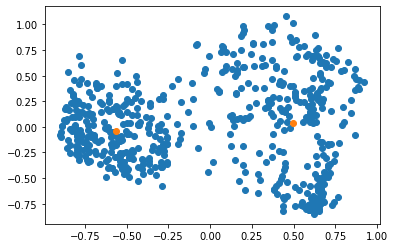

In [7]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow(levels_reduced):
    prev_sse = -1
    now_max = 0
    elbow = 0
    for n_cluster in range(1,min(30,len(levels_reduced))):
        kmeans = KMeans(n_clusters=n_cluster,random_state=0)
        kmeans.fit(levels_reduced)
        sse = kmeans.inertia_
        if prev_sse >0:
            if abs(sse-prev_sse)>now_max:
                now_max = abs(sse - prev_sse)
                elbow = n_cluster
        prev_sse = sse
    return elbow

pca = PCA(n_components=2)
levels_reduced = pca.fit_transform(playable_levels_numpy)
plt.scatter(levels_reduced[:, 0], levels_reduced[:, 1])
kmeans = KMeans(n_clusters=elbow(levels_reduced), random_state=0)
kmeans.fit(levels_reduced)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])

indices = []
for center in kmeans.cluster_centers_:
    dist = 1000
    index = -1
    for i,lr in enumerate(levels_reduced):
        dist_tmp = (center[0]-lr[0])**2+(center[1]-lr[1])**2
        if dist_tmp < dist:
            dist= dist_tmp
            index = i
    indices.append(index)
print(indices)
levels_reduced[indices]

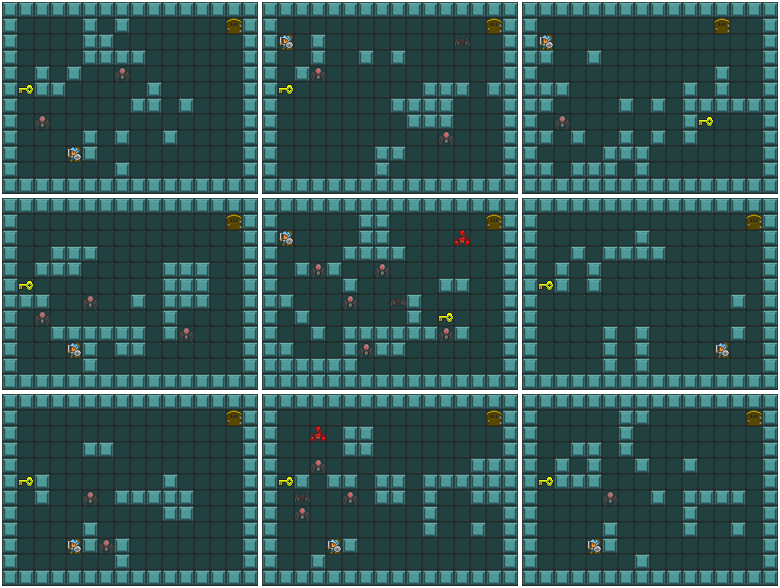

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

env = Env(config.env_name,config.env_version)
visualizer = GVGAILevelVisualizer(env)

latents_for_eval = torch.randn(
    100,
    config.latent_size,
).to(device)
output_levels = generator(latents_for_eval)
level_strs = tensor_to_level_str(config.env_name, output_levels)
playable_levels = []
playable_count = 0
for level_str in level_strs:
    if check_playable(level_str, config.env_fullname):
        playable_levels.append(level_str)

p_level_img = [
    torch.Tensor(
        np.array(visualizer.draw_level(lvl)).transpose(
            2, 0, 1
        )
        / 255.0
    )
    for lvl in playable_levels[:9]
]
grid_level_img = make_grid(
    p_level_img, nrow=3, padding=0)

img = Image.fromarray((grid_level_img.transpose(0, 2).transpose(0, 1).numpy()*255).astype(np.uint8))
img.show()


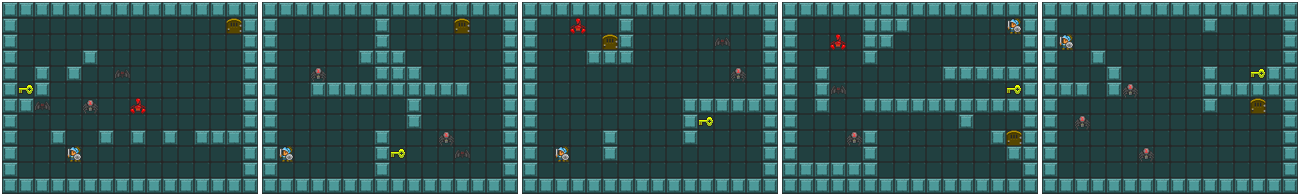

Ave. Wall: 71.4
Ave. Floor: 114.4
Ave. Enemy: 3.2
Std. Wall: 8.2365041127896
Std. Floor: 8.06473806146238
Std. Enemy: 0.39999999999999997
34.8


In [ ]:
import math
import matplotlib.pyplot as plt
from PIL import Image
env = Env(config.env_name,config.env_version)
visualizer = GVGAILevelVisualizer(env)

lvl_strs = visualizer.game.get_original_levels(
    f'/root/mnt/pcg/GVGAI-GAN/gan/data/level/{config.env_fullname}/originals')

p_level_img = [
    torch.Tensor(
        np.array(visualizer.draw_level(lvl)).transpose(
            2, 0, 1
        )
        / 255.0
    )
    for lvl in lvl_strs
]
grid_level_img = make_grid(
    p_level_img, nrow=5, padding=0)

img = Image.fromarray((grid_level_img.transpose(
    0, 2).transpose(0, 1).numpy() * 255).astype(np.uint8))
img.show()

n_w = 0
n_f = 0
n_e = 0
n = 0

vw = []
vf = []
ve = []

for level in lvl_strs:
    w = 0
    f = 0
    e = 0
    n += 1
    for c in level:
        if c == 'w':
            w += 1
            n_w += 1
        elif c == '.':
            f += 1
            n_f += 1
        elif c in ['1','2','3']:
            e += 1
            n_e += 1
    vw.append(w)
    vf.append(f)
    ve.append(e)

print('Ave. Wall:', n_w/n)
print('Ave. Floor:', n_f/n)
print('Ave. Enemy:', n_e/n)
sw = 0
sf = 0
se = 0
for nw,nf,ne in zip(vw,vf,ve):
    sw += (nw - n_w / n)**2
    sf += (nf - n_f / n)**2
    se += (ne - n_e / n)**2
print('Std. Wall:', math.sqrt(sw / n))
print('Std. Floor:', math.sqrt(sf / n))
print('Std. Enemy:', math.sqrt(se / n))
sum = 0
obj_sum = 0
for i in range(len(lvl_strs)):
    for j in range(len(lvl_strs)):
        if i == j:
            continue
        obj_sum += check_level_object_duprecated(
            lvl_strs[i], lvl_strs[j])
        sum += check_level_hamming(lvl_strs[i], lvl_strs[j])
        n += 1

print(sum/n)

In [ ]:
# import glob

# files = glob.glob("/root/mnt/GVGAI-GAN/gan/data/level/zelda/generated_good/*")

# real_levels = []
# for file in files:
#     with open(os.path.join("/root/mnt/GVGAI-GAN/gan/data/level/zelda/generated_good/",file),'r') as f:
#         s = f.read()
#         real_levels.append(s)
# hamming = 0
# n = 0
# for i in range(0, len(real_levels)):
#     for j in range(i + 1, len(real_levels)):
#         hamming += check_level_hamming(
#             real_levels[i], real_levels[j])
#         n += 1
# print(hamming/(n)/(12*16))

In [ ]:
# import glob

# files = glob.glob("/root/mnt/GVGAI-GAN/gan/data/level/zelda/generated_large/*")

# real_levels = []
# for file in files:
#     with open(os.path.join("/root/mnt/GVGAI-GAN/gan/data/level/zelda/generated_large/", file), 'r') as f:
#         s = f.read()
#         real_levels.append(s)
# hamming = 0
# n = 0
# for i in range(0, len(real_levels)):
#     for j in range(i + 1, len(real_levels)):
#         hamming += check_level_hamming(
#             real_levels[i], real_levels[j])
#         n += 1
# print(hamming/(n)/(12*16))


In [ ]:
# import glob

# files = glob.glob("/root/mnt/GVGAI-GAN/gan/data/level/zelda/originals/*")

# real_levels = []
# for file in files:
#     with open(os.path.join("/root/mnt/GVGAI-GAN/gan/data/level/zelda/originals/", file), 'r') as f:
#         s = f.read()
#         real_levels.append(s)
# hamming = 0
# n = 0
# for i in range(0, len(real_levels)):
#     for j in range(i + 1, len(real_levels)):
#         hamming += check_level_hamming(
#             real_levels[i], real_levels[j])
#         n += 1
# print(hamming/(n)/(12*16))

# n_w = 0
# n_f = 0
# n_e = 0
# n = 0
# for level in real_levels:
#     n += 1
#     for c in level:
#         if c == 'w':
#             n_w += 1
#         elif c == '.':
#             n_f += 1
#         elif c in ['1', '2', '3']:
#             n_e += 1

# print('Ave. Wall:', n_w/n)
# print('Ave. Floor:', n_f/n)
# print('Ave. Enemy:', n_e/n)


In [ ]:
# import glob

# files = glob.glob("/root/mnt/GVGAI-GAN/gan/data/level/zelda/random/*")

# real_levels = []
# for file in files:
#     with open(os.path.join("/root/mnt/GVGAI-GAN/gan/data/level/zelda/random/", file), 'r') as f:
#         s = f.read()
#         real_levels.append(s)
# hamming = 0
# n = 0
# for i in range(0, len(real_levels)):
#     for j in range(i + 1, len(real_levels)):
#         hamming += check_level_hamming(
#             real_levels[i], real_levels[j])
#         n += 1
# print(hamming/(n)/(12*16))


In [ ]:
# if config.cuda:
#     device = torch.device(
#         "cuda" if torch.cuda.is_available else "cpu")
#     print("device : cuda")
# else:
#     device = torch.device("cpu")
#     print("device : cpu")
# generator = Generator(
#     out_dim=config.input_shape[0],
#     shapes=config.model_shapes,
#     z_shape=(config.latent_size,),
#     filters=config.generator_filters,
#     use_conditional=config.use_conditional
# ).to(device)

# model_path = os.path.join(
#     "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/none-795", "models.tar")
# load_model = torch.load(model_path)
# generator.load_state_dict(load_model["generator"])

# x = torch.randn(config.latent_size).to(device)

# # es = cma.CMAEvolutionStrategy(config.latent_size*[0], 0.5)
# # es.optimize(fitness)

# def fitness(x: torch.Tensor):
#     x = np.array(x)
#     latent = torch.FloatTensor(x).view(1, -1, 1, 1)
#     level = generator(x)
#     level_str = tensor_to_level_str(level)
#     playable = check_playable(level_str)
#     eval = eval(level_str)
#     return playable*300 + eval

# def eval(level_str):
#     wall = 0
#     enemy = 0
#     for s, i in enumerate(level_str):
#         for c, j in enumerate(level_str):
#             if c == 'w':
#                 wall += 1
#             if c in ['1', '2', '3']:
#                 enemy += 1
#     return wall + enemy
